## Tutorial: Train your  ML model in Azure


This notebook contains an end-to-end walkthrough of submitting GPU intensive job using Azure Machine Learning service

Steps:

* Intialize an AzureML workspace
* Register a datastore and upload data
* Create an experiment
* Provision a compute target
* Create an Estimator
* Configure and Run
* Hyperparameter Tuning
* Model deployment (optional)


## What is Azure Machine Learning service?
Azure Machine Learning service is a cloud service that you can use to develop and deploy machine learning models. Using Azure Machine Learning service, you can track your models as you build, train, deploy, and manage them, all at the broad scale that the cloud provides.

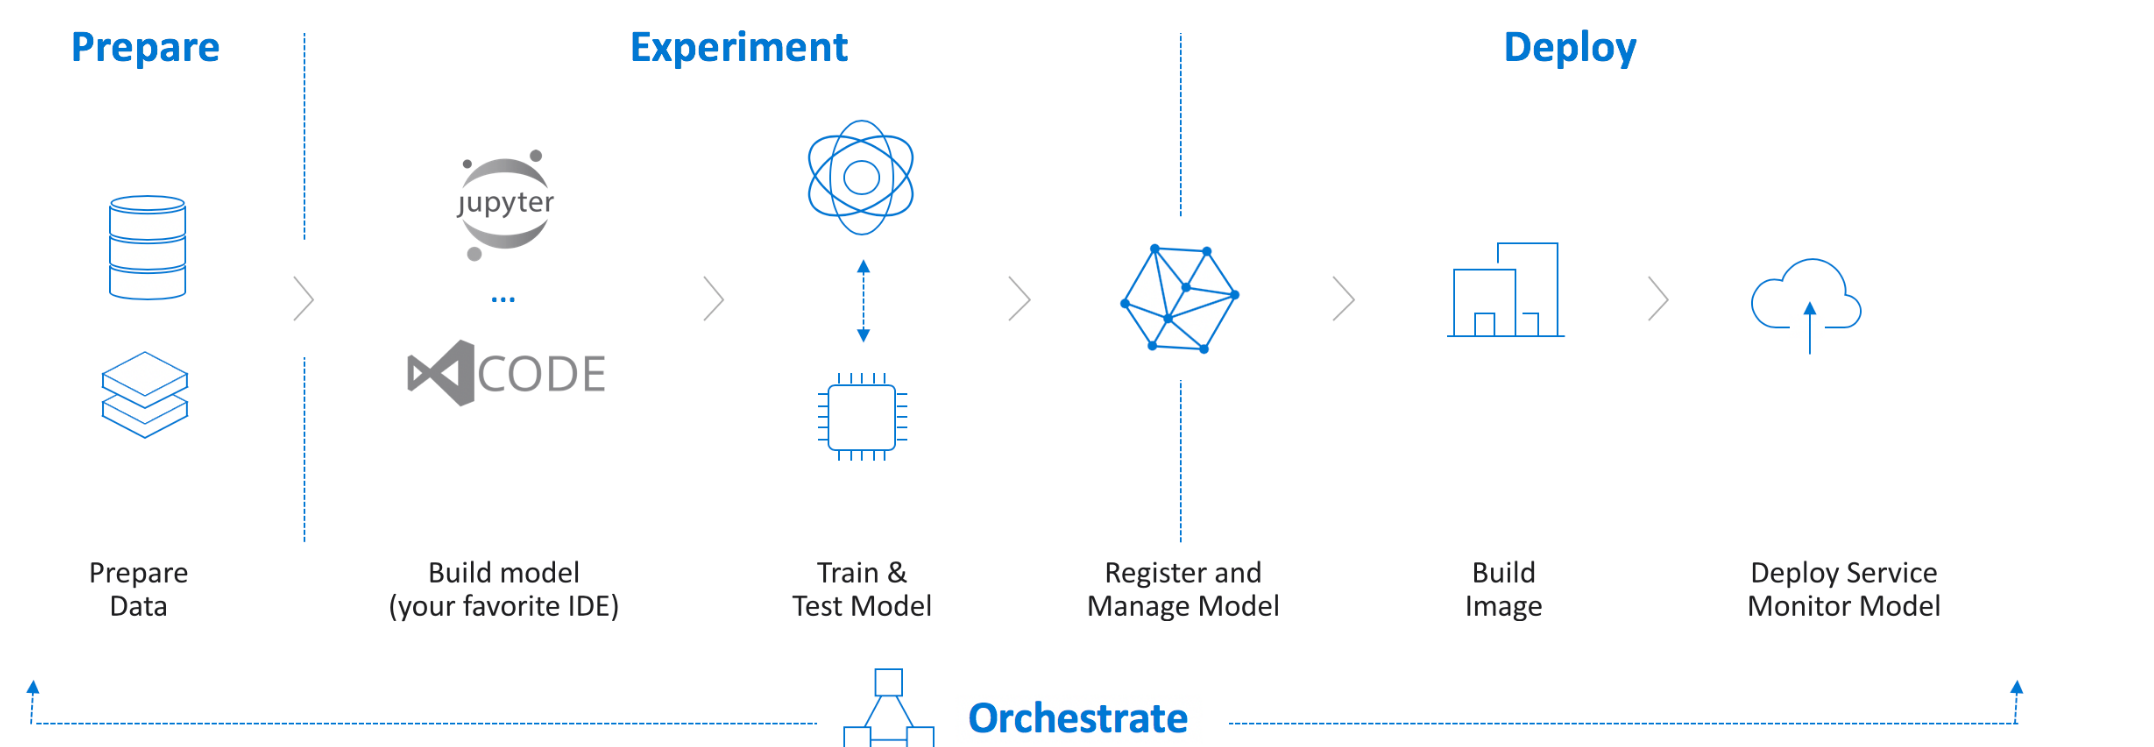

## Setup Python SDK

Setup Conda/Miniconda

Download and install Miniconda. Select the Python 3.7 version or later. Don't select the Python 2.x version.

AzureML Python SDK

Install the Python SDK: make sure to install notebook, and contrib


```console
conda create -n azureml -y Python=3.6 ipywidgets nb_conda
conda activate azureml
pip install --upgrade azureml-sdk[notebooks,contrib] scikit-image tensorflow tensorboardX --user 
jupyter nbextension install --py --user azureml.widgets
jupyter nbextension enable azureml.widgets --user --py
```

You will need to restart jupyter after this Detailed instructions are here: https://docs.microsoft.com/en-us/azure/machine-learning/service/quickstart-create-workspace-with-python

In [97]:
import azureml.core
print("SDK version:", azureml.core.VERSION)

SDK version: 1.15.0


## Connect to ml workspace


The best practice for using Azure ml service is to create one workspace for your v-team, setup your own gpu compute target (though you still need to share quota with other members) and submit your job to that gpu cluster. 

create one ml workspace if not already exists

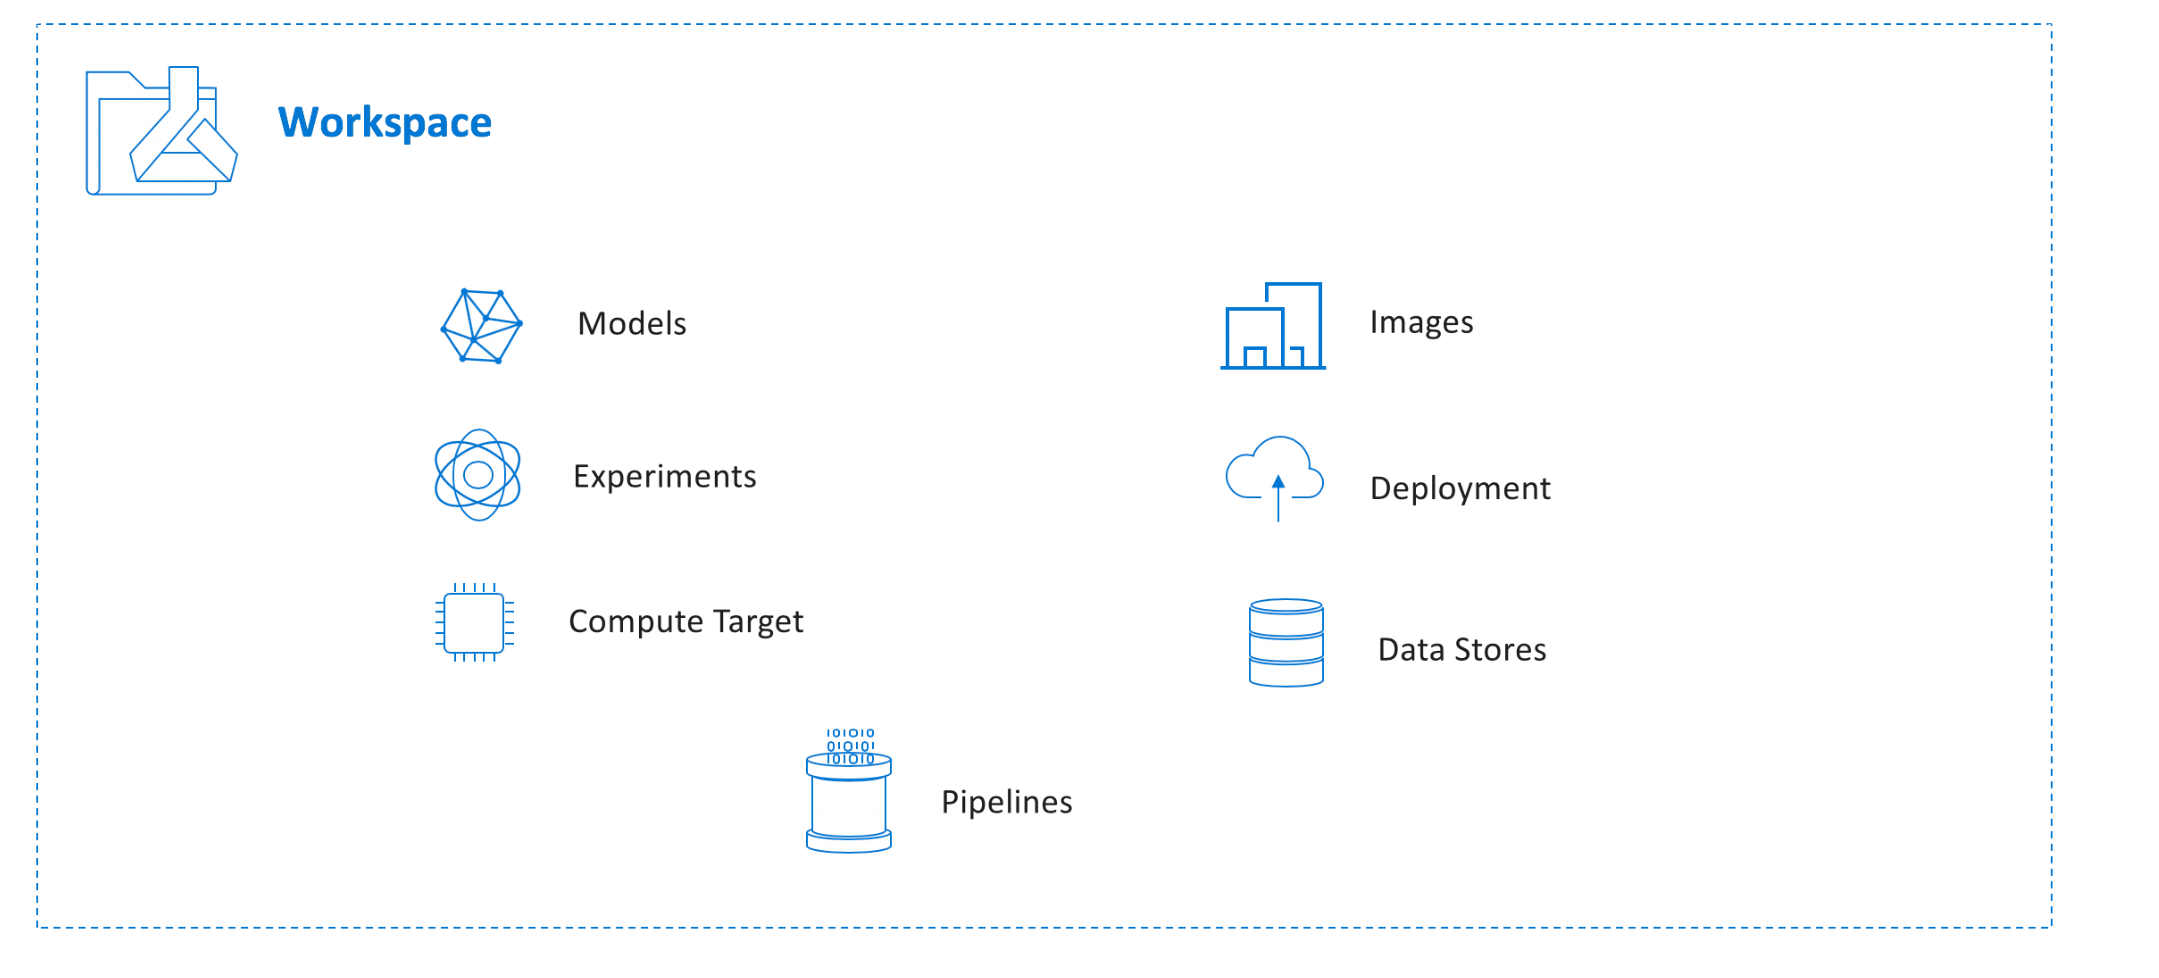

In [98]:
from azureml.core import Workspace

# switch to my own
#WARNING - Note, we have launched a browser for you to login. For old experience with device code, use "az login --use-device-code"
#WARNING - You have logged in. Now let us find all the subscriptions to which you have access...
#WARNING - Note, we have launched a browser for you to login. For old experience with device code, use "az login --use-device-code"
#Interactive authentication successfully completed.
#Performing interactive authentication. Please follow the instructions on the terminal.
#WARNING - You have logged in. Now let us find all the subscriptions to which you have access...
#Interactive authentication successfully completed.
#Workspace not found
# both group the same


#subscription_id = "4a66f470-dd54-4c5e-bd19-8cb65a426003"
#resource_group  = "AML_Playground"
#workspace_name  = "Teams_ws"

subscription_id = "ddb33dc4-889c-4fa1-90ce-482d793d6480"
resource_group = "DevExp"
workspace_name = "DevExperimentation"



try:
    #print('1')
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    #print('2')
    ws.write_config()
    print('Library configuration succeeded')
    print(ws.get_details()['id'])

    print('https://ms.portal.azure.com/#@microsoft.onmicrosoft.com/resource' + ws.get_details()['id'])
except:
    print('Workspace not found')

Library configuration succeeded
/subscriptions/ddb33dc4-889c-4fa1-90ce-482d793d6480/resourceGroups/DevExp/providers/Microsoft.MachineLearningServices/workspaces/DevExperimentation
https://ms.portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/ddb33dc4-889c-4fa1-90ce-482d793d6480/resourceGroups/DevExp/providers/Microsoft.MachineLearningServices/workspaces/DevExperimentation


In [99]:
#resource group in email inference
{
    "subscription_id": "58f08321-00aa-4ada-bd53-421ecd063782",
    "resource_group": "Compliant_LU",
    "workspace_name": "Teams_ws"
}


{'subscription_id': '58f08321-00aa-4ada-bd53-421ecd063782',
 'resource_group': 'Compliant_LU',
 'workspace_name': 'Teams_ws'}

## Create AmlCompute
Introduction to AmlCompute

Azure Machine Learning Compute is managed compute infrastructure that allows the user to easily create single to multi-node compute of the appropriate VM Family. It is created within your workspace region and is a resource that can be used by other users in your workspace. It autoscales by default to the max_nodes, when a job is submitted, and executes in a containerized environment packaging the dependencies as specified by the user.


In [100]:
from azureml.core.compute import AmlCompute, ComputeTarget

# cluster_name , different from compute name you create
#cluster_name = "p100cluster"
cluster_name = "P100-DualGPU"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    # comment since do not want to create
    #compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6s_v2', 
    #                                                       idle_seconds_before_scaledown=1800,
    #                                                       min_nodes=0, 
    #                                                       max_nodes=10)
    # create the cluster
    #compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    #compute_target.wait_for_completion(show_output=True)

Found existing compute target.


## Connect a datastore and upload data


When you have large data and model, you need to create one seperate Datastore.

If not, AML will have error and you can't track your outputs. 

Each workspace is associated with a default Azure Blob datastore named 'workspaceblobstore'. In this work, we use this default datastore to store our local data.

In [101]:
ds = ws.get_default_datastore()

We can also register a new datastore and link to the existing workspace. Show storge account: https://ms.portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/4a66f470-dd54-4c5e-bd19-8cb65a426003/resourceGroups/AML_Playground/providers/Microsoft.Storage/storageAccounts/teamsws4000114466/overview

In [102]:
# Register the datastore with the workspace
# i have arlead registered through portal so i do not need this
#ds_new = Datastore.register_azure_blob_container(workspace=ws, 
#                                             datastore_name='BERT_Preprocessed_Data',
#                                             container_name='data',
#                                             account_name='<name goes here>', 
#                                             account_key='<key goes here>'
#                                            )

# here to register if not yet through portal  
#ds_new = Datastore.register_azure_blob_container(workspace=ws, 
#                                             datastore_name='chiecha_datastore',
#                                             container_name='chiecha',
#                                             account_name='chiecha', 
#                                             account_key='o+JvX+MkXst5A70VbZAk7zSF6pHAQs5UMWRFC1csQWu61ogEPTaf67i8FZsihSYVaMgx4h99zAAWmoB/9mQWrw=='
#
#                                            )
from azureml.core import Datastore
ds = Datastore.get(ws, 'chiecha_datastore')



### Upload data locally

### Upload Data from aether
In azureml, there is no easy approach to link to cosmos, which makes data access difficulty. A hacky solution is to use aether for data access and data pre-processing. We can do data pre-processing in aether and upload data into Azure Blob

Ref: aether://experiments/a176585f-ab53-47f9-a329-7e77a63f3a9a

An alternative approach is to use visual interface/azure ml pipeline to handle data processing, in that case we won't need aether for feature processing. However, visual interface updates very frequently and only provides limited data sources

In [103]:

#$AZUREML_DATAREFERENCE_e2b58eeb943a48968b3f9e7c5c7a9925
#reference can be used in python module(?? not sure, check in the future) 

#upload local model
##model_path_on_datastore = 'Teams_slot_model' #cased model,vocab is too small? Do not have frequent word like common
##ds_model = ds.path(model_path_on_datastore)
##ds.upload(src_dir=r'D:\dl_repo\Tagging_data\bert-base-English-cased-pytorch',
##          target_path= model_path_on_datastore,
##          overwrite=False,
##          show_progress=True)
##print(ds_model.as_mount())

#upload unsupervised local model
##model_path_on_datastore = 'Communication_slot_model_unsupervised' #cased model,vocab is too small? Do not have frequent word like common
##ds_model_unsupervised = ds.path(model_path_on_datastore)
##ds.upload(src_dir=r'D:\dl_repo\Data_model\Communication_unsupervised',
##          target_path= model_path_on_datastore,
##          overwrite=False,
##          show_progress=True)
##print(ds_model_unsupervised.as_mount())

#upload local data set
##path_on_datastore = 'datasets/Teams_communication'
##ds_data_communication = ds.path(path_on_datastore)
##ds.upload(src_dir=r'D:\dl_repo\Data_model\Communication_data',
##          target_path= path_on_datastore,
##          overwrite=False,
##          show_progress=True)

# files training data source
#path_on_datastore = 'resource/Data'
#ds_data_files = ds.path(path_on_datastore)
#ds.upload(src_dir=r'E:\fileAnswer_data_synthesis\CMF_training\resource\Data',
#          target_path= path_on_datastore,
#          overwrite=False,
#          show_progress=True)

# git data source for normal domain training
#path_on_datastore = 'resource/Data'
#ds_data_files = ds.path(path_on_datastore)

#ds.upload(src_dir=r'E:\CoreScienceDataStaging\datasources\Files\resource\Data',
#          target_path= path_on_datastore,
#          overwrite=False,
#          show_progress=True)


# local data source for normal domain training
'''
path_on_datastore = './azureml_data'
ds_data_files = ds.path(path_on_datastore)
ds.upload(src_dir=r'E:\azure_ml_notebook\azureml_data',
          target_path= path_on_datastore,
          overwrite=True,
          show_progress=True)
'''

# 

# training script

training_script_on_datastore = './training_script'
ds_data_files = ds.path(training_script_on_datastore)
ds.upload(src_dir=r'E:\azure_ml_notebook\training_script',
          target_path= training_script_on_datastore,
          overwrite=True,
          show_progress=True)





Uploading an estimated of 7 files
Uploading E:\azure_ml_notebook\training_script\basic_onnx_test.py
Uploaded E:\azure_ml_notebook\training_script\basic_onnx_test.py, 1 files out of an estimated total of 7
Uploading E:\azure_ml_notebook\training_script\hugging_face_load.py
Uploaded E:\azure_ml_notebook\training_script\hugging_face_load.py, 2 files out of an estimated total of 7
Uploading E:\azure_ml_notebook\training_script\train_horovod.py
Uploaded E:\azure_ml_notebook\training_script\train_horovod.py, 3 files out of an estimated total of 7
Uploading E:\azure_ml_notebook\training_script\train_horovod_1216_2020v1.py
Uploaded E:\azure_ml_notebook\training_script\train_horovod_1216_2020v1.py, 4 files out of an estimated total of 7
Uploading E:\azure_ml_notebook\training_script\train_horovod_backup.py
Uploaded E:\azure_ml_notebook\training_script\train_horovod_backup.py, 5 files out of an estimated total of 7
Uploading E:\azure_ml_notebook\training_script\train_horovod_before_add_comment_1

$AZUREML_DATAREFERENCE_7f6c716f1b8e432a8903b5632c815539

In [104]:
# Create an experiment
# Create an Experiment to track all the runs in your workspace. 

In [105]:
#from azureml.core import Experiment

#experiment_name = 'Teams_tutorial' 
#experiment = Experiment(ws, name=experiment_name)


# minic and create an domain training experiemnt
from azureml.core import Experiment

experiment_name = 'files_domain_classification_using_bert' 
experiment = Experiment(ws, name=experiment_name)




## Create a PyTorch estimator
The AML SDK's PyTorch estimator enables you to easily submit PyTorch training jobs for both single-node and distributed runs. For more information on the PyTorch estimator, refer here. The following code will define a single-node PyTorch job.

In [106]:
##BATCH AI
from azureml.train.dnn import PyTorch


## original python estimator
'''
script_params = {
    #'--data_dir': ds_data.as_mount(),
    #'--data_dir': 'teams_data', #update for golden data
    '--data_dir': ds_data_communication.as_mount(), #update for communication data
    #'--teacher_model_path':ds_model_pretrained.as_mount(),
    '--teacher_model_path':ds.path(f'bert_data/outputs').as_mount(),
    '--bert_model': ds_model.as_mount(),
    '--task_name':'ner',
    '--output_dir':'./outputs',
    '--do_train':'',
    '--do_eval':'',
    #'--learning_rate':'0.001',#add large learning rate for student model
    '--learning_rate':'1e-4',#smaller learning rate given init
    '--num_train_epochs':'10',
    '--warmup_proportion':'0.1',
    '--max_seq_length':'32',
    '--train_batch_size':'64',
    "--temperature": '1',
    "--alpha": '1',
    "--unsupervised_train_corpus":'./lm_data/train.txt' #add for debug
    
    #'--multi_gpu':'',
}

estimator10 = PyTorch(source_directory='..', 
                    script_params=script_params,
                    compute_target=compute_target, 
                    entry_script='distiller.py',
                    #pip_packages=['pandas','pytorch-pretrained-bert==0.4.0','seqeval==0.0.5'],
                    #pip_packages=['pandas','pytorch-pretrained-bert==0.6.1','seqeval==0.0.5','nltk'],
                    pip_packages=['pandas','transformers','pytorch-pretrained-bert==0.6.1','seqeval==0.0.5','nltk'],
                    use_gpu=True)
'''
#####################################
#estimator from here
#and use this section , ignore all cells after this cell
#https://github.com/vilcek/fine-tuning-BERT-for-text-classification/blob/master/04-data-classification-aml.ipynb


#######################################


### for debug if data is reable
from azureml.core import Dataset

# method 1 fail
'''
dataset = Dataset.get_by_name("DevExperimentation", name='complaints_after')
file_name = dataset.download()[0]
df = pd.read_csv(file_name)
print(df.head())
'''


# method 2
# dataset register
#https://github.com/vilcek/fine-tuning-BERT-for-text-classification/blob/master/#03-data-registration.ipynb
#training_datastore_path = [(ds, './azureml_data/complaints_after.tsv')]
#bigger dataset
training_datastore_path = [(ds, './azureml_data/files_domain_training_contexual_answer_small.tsv')]
# small dataset
#training_datastore_path = [(ds, './azureml_data/files_domain_training_contexual_answer.tsv')]


training_dataset_obj = Dataset.File.from_files(path=training_datastore_path)

training_dataset_name = 'training_data_set'
training_dataset_description = 'training_data_set description'
training_dataset = training_dataset_obj.register(workspace=ws, name=training_dataset_name, description=training_dataset_description, create_new_version=True)

# for debug old format
#import pandas as pd
#file_name = training_dataset.download()[0]
#df = pd.read_csv(file_name)
#print(df.head())

# for debug new format
import pandas as pd
file_name = training_dataset.download()[0]
df = pd.read_csv(file_name, sep='\t', encoding="utf-8")
print(df.head())





from azureml.core.runconfig import MpiConfiguration
from azureml.train.hyperdrive import GridParameterSampling
from azureml.train.hyperdrive import HyperDriveConfig
from azureml.train.hyperdrive import PrimaryMetricGoal
from azureml.train.hyperdrive.parameter_expressions import choice


script_folder = './training_script'

# old dataset name
#script_params = {
#    '--dataset_name': 'Consumer Complaints Dataset'
#}

# new dataset name
script_params = {
    '--dataset_name': 'training_data_set'
}



estimator = PyTorch(source_directory = script_folder,
                    compute_target = compute_target,
                    entry_script = 'train_horovod.py',
                    script_params = script_params,
                    use_gpu = True,
                    node_count=8,
                    process_count_per_node=1,
                    distributed_training=MpiConfiguration(),
                    pip_packages = ['sklearn', 'joblib', 'transformers', 'azureml-dataprep[fuse,pandas]'])


param_sampling = GridParameterSampling({
    'batch_size': choice(32),
    'learning_rate': choice(1e-5),
    'adam_epsilon': choice(1e-8),
    'num_epochs': choice(5)})


#horovod
#https://docs.microsoft.com/en-us/azure/machine-learning/how-to-train-pytorch
hyperdrive_run_config = HyperDriveConfig(estimator = estimator,
                                         hyperparameter_sampling = param_sampling,
                                         policy = None,
                                         primary_metric_name = 'validation loss',
                                         primary_metric_goal = PrimaryMetricGoal.MINIMIZE,
                                         max_total_runs = 1,
                                         max_concurrent_runs = 1)


#hyperdrive_run = exp.submit(hyperdrive_run_config)
hyperdrive_run = experiment.submit(hyperdrive_run_config)
# show detail
from azureml.widgets import RunDetails
RunDetails(hyperdrive_run).show()


# this is to show metric so comment it at first

hyperdrive_run.wait_for_completion(show_output = False)

children = list(hyperdrive_run.get_children())
metricslist = {}
i = 0

for single_run in children:
    results = {k: v for k, v in single_run.get_metrics().items() if isinstance(v, float)}
    parameters = single_run.get_details()['runDefinition']['arguments']
    try:
        results['batch_size'] = parameters[3]
        results['learning_rate'] = parameters[5]
        results['adam_epsilon'] = parameters[7]
        results['num_epochs'] = parameters[9]
        metricslist[i] = results
        i += 1
    except:
        pass

rundata = pd.DataFrame(metricslist).sort_index(1).T.sort_values(by = ['validation loss'], ascending = True)
rundata


# get the best run id
#https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/ml-frameworks/pytorch/train-hyperparameter-tune-deploy-with-pytorch/train-hyperparameter-tune-deploy-with-pytorch.ipynb
best_run = hyperdrive_run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
print(best_run)
#best_run.id

model = best_run.register_model(model_name = 'my_small_model', model_path = 'outputs/model.pt')
print(model.name, model.id, model.version, sep = '\t')

from azureml.core.model import Model
# will complain empty space
#model = Model.register(model_path = "./outputs",
#                       model_name = "my_small_model",
#                       description = "Sentiment analysis model trained outside Azure Machine Learning",
#                       workspace = ws)

# will complain 
#Error, provided model path "./outputs/pytorch_model.bin" cannot be found
#model = Model.register(model_path ='./outputs/pytorch_model.bin',
#                       model_name = "my_small_model",
#                       description = "Sentiment analysis model trained outside Azure Machine Learning",
#                       workspace = ws)





WARNING - framework_version is not specified, defaulting to version 1.4.
WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.
WARNING - If 'arguments' has been provided here and arguments have been specified in 'run_config', 'arguments' provided in ScriptRunConfig initialization will take precedence.
   TurnNumber  PreviousTurnDomain  \
0           0                 NaN   
1           0                 NaN   
2           0                 NaN   
3           0                 NaN   
4           0                 NaN   

                                               query  domain  
0                                send dri guide file       1  
1                          show me rick varvel files       1  
2  voice skill61699 test attachments from last tu...       1  
3                             download crista tambor       1  
4                  spreadsheet zhen

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

ActivityFailedException: ActivityFailedException:
	Message: Activity Failed:
{
    "error": {
        "code": "UserError",
        "message": "User errors were found in at least one of the child runs.",
        "details": [],
        "messageParameters": {}
    },
    "time": "0001-01-01T00:00:00.000Z"
}
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Activity Failed:\n{\n    \"error\": {\n        \"code\": \"UserError\",\n        \"message\": \"User errors were found in at least one of the child runs.\",\n        \"details\": [],\n        \"messageParameters\": {}\n    },\n    \"time\": \"0001-01-01T00:00:00.000Z\"\n}"
    }
}

# Set up your running environment

You can create your own virtual environment. It takes a while the first time you submit the job. If you do not change dependency, the job submission will be fast.
We can also find the enivronemnt configuration in azure machine learning extension

In [ ]:

# here using default mange is enough unless you want to specify the detail
# this is igonred since using estimator instead of estimator10 in the section 'Create a PyTorch estimator' for convenience
'''
print(estimator10.run_config.environment.docker.base_image)
print(estimator10.conda_dependencies.serialize_to_string())
'''

# Submit and Monitor your run

You can also find your previous runs if your open the azure portal

In [ ]:
# this has definied similary (not exact the sams) to the section 'Create a PyTorch estimator' for convenience
'''
run = experiment.submit(estimator10)
from azureml.widgets import RunDetails
RunDetails(run).show()
'''

## What happens during a run?
If you are running this for the first time, the compute target will need to pull the docker image, which will take about 2 minutes. This gives us the time to go over how a Run is executed in Azure Machine Learning.


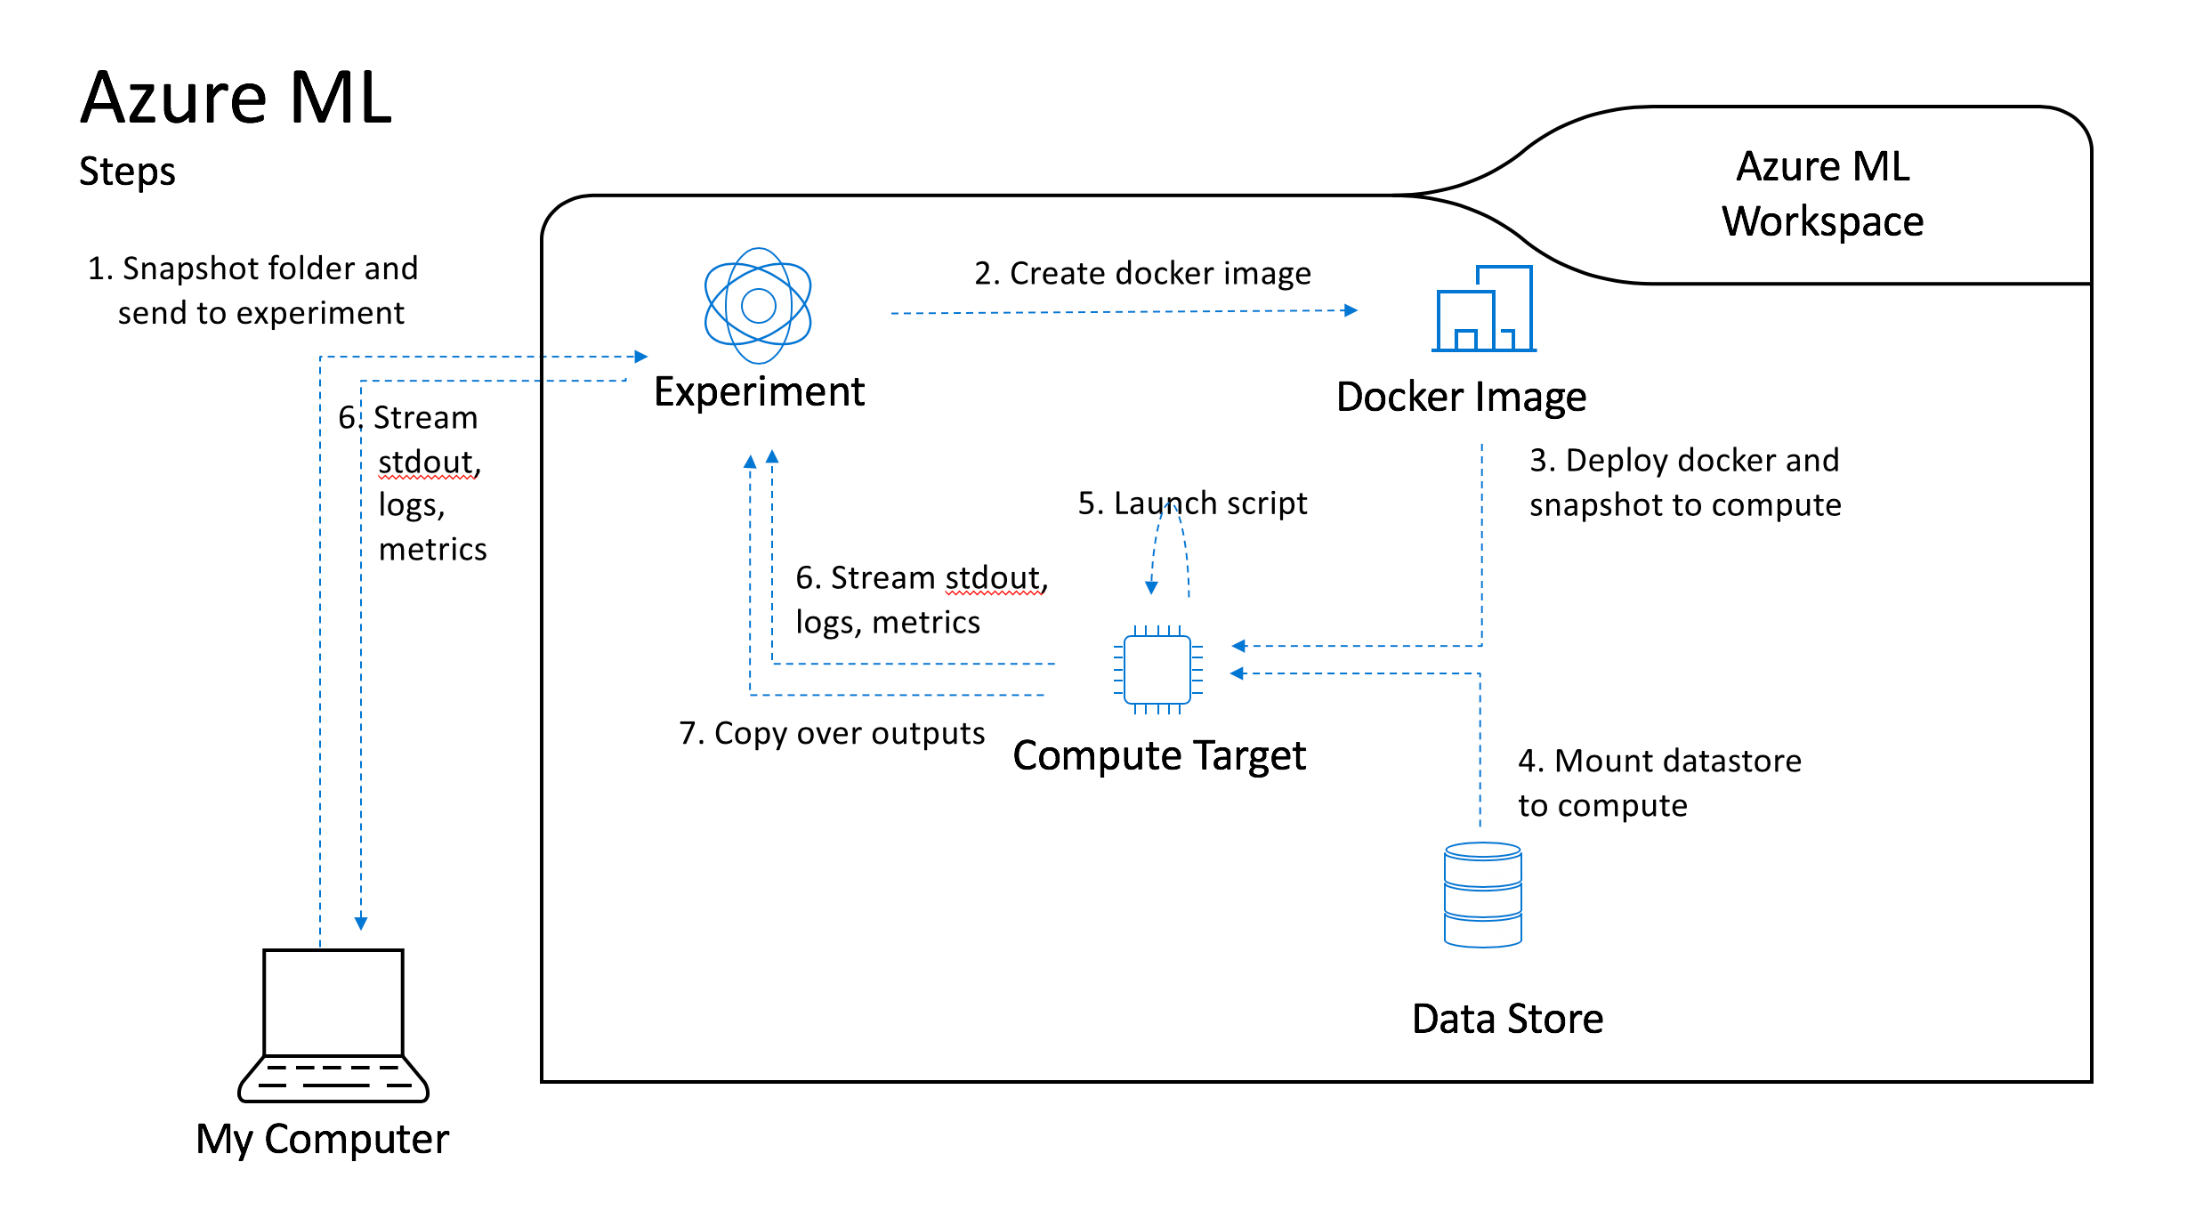

## Hyperparameter Tuning

Now that you have trained an initial model, you can tune the hyperparameters of this model to optimize model performance. Azure ML allows you to automate this tuning, in an efficient manner via early termination of poorly performing runs.

You can configure your Hyperparamter Tuning experiment by specifying the following info -

* Define the hyparparameter space - specify ranges, distribution and sampling
* Early Termination policy
* Optimization metric

Ref: https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.hyperdrive?view=azure-ml-py


In [ ]:
# this has definied similary (not exact the sams) to the section 'Create a PyTorch estimator' for convenience
'''
from azureml.widgets import RunDetails
from azureml.train.hyperdrive import *
import math
ps = RandomParameterSampling(
    {
        '--learning_rate': loguniform(math.log(1e-4), math.log(1e-3))
        #'--batch_size': choice(1e-4,2e-4,3e-4,1e-3)
    }
)

policy = BanditPolicy(evaluation_interval=2, slack_factor=0.2)


hdc = HyperDriveConfig(estimator=estimator10, 
                          hyperparameter_sampling=ps, 
                          policy=policy, 
                          primary_metric_name='best_val_f1', 
                          primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                          max_total_runs=4,
                          max_concurrent_runs=4)
'''

In [ ]:
# this has definied similary (not exact the sams) to the section 'Create a PyTorch estimator' for convenience
'''
hd_run = experiment.submit(hdc)
RunDetails(hd_run).show()
'''

## Find and register the best model
Once all the runs complete, we can find the run that produced the model with the highest evaluation f1.

ref: https://github.com/microsoft/AzureML-BERT/blob/master/finetune/PyTorch/notebooks/Pretrained-BERT-NER.ipynb

In [23]:
## this has definied similary (not exact the sams) to the section 'Create a PyTorch estimator' for convenience
'''
best_run = hdc.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
print(best_run)
print('Best Run is:\n  F1: {0:.5f} \n  Learning rate: {1:.8f}'.format(
        best_run_metrics['best_val_f1'][-1]
     ))
'''

NameError: name 'hdc' is not defined

## Deploy the model 

TODO  :)

https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where

For more advanced tutorials

Ref: https://ml.azure.com/tutorials?wsid=/subscriptions/58f08321-00aa-4ada-bd53-421ecd063782/resourcegroups/Compliant_LU/workspaces/Teams_ws

Get output pytorch model  if  it is unregisted by id

In [96]:


#==========================
# useful link
# https://docs.aws.amazon.com/zh_cn/dlami/latest/devguide/tutorial-onnx-pytorch-cntk.html
# https://github.com/onnx/tutorials/blob/master/tutorials/PytorchOnnxExport.ipynb

# pytorch_model.bin a PyTorch dump of a pre-trained instance
# ? it seems this is not a final model output based on EmailSearch_self_training experiement
# model.pt might be the correct model
#https://modelzoo.co/model/pytorch-pretrained-bert
#https://docs.microsoft.com/en-us/azure/machine-learning/how-to-train-pytorch



# this link has onnx output 
# https://ml.azure.com/experiments/id/6b8c8998-c8d9-41d5-812c-1394e66f64c2/runs/019c292a-2ddb-48b3-a486-90d6bd185a69?wsid=/subscriptions/ddb33dc4-889c-4fa1-90ce-482d793d6480/resourceGroups/DevExp/workspaces/DevExperimentation&tid=72f988bf-86f1-41af-91ab-2d7cd011db47


# tihs issue looks like the one i encountered
#https://github.com/onnx/onnx/issues/2757
#https://discuss.pytorch.org/t/problem-in-converting-pytorch-model-pytorch-model-bin-to-model-pt/79939


# how to define dummy input
#https://github.com/onnx/onnx/issues/654



# reload pytorch model bin

# dummy input functionalnity
#https://github.com/onnx/tutorials/issues/158
#https://stackoverflow.com/questions/54254313/transferring-pretrained-pytorch-model-to-onnx



# fine tune 
# hugging face dataset
# https://huggingface.co/transformers/custom_datasets.html

#==========================


#print(experiment.get_runs())


#https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.run(class)?view=azure-ml-py
# https://ml.azure.com/experiments/id/280220b8-b73f-4277-88d5-63700586f5b2?wsid=/subscriptions/ddb33dc4-889c-4fa1-90ce-482d793d6480/resourceGroups/DevExp/workspaces/DevExperimentation&tid=common
# here to find run id and load again

from azureml.core import Experiment, Run
# get output file name
# here is run57 result

run = Run(Experiment(workspace = ws, name=experiment_name), 'HD_e34f95a4-a1a5-4edf-b216-42e5dd420b7a_0')
# for deubg 
#print(run.get_file_names())

# register the model by model path
# ? not sure if this is correct oath
#https://stackoverflow.com/questions/55277334/#how-can-i-register-in-azure-ml-service-a-machine-learning-model-trained-locally
#https://docs.microsoft.com/en-us/azure/machine-learning/how-to-train-pytorch
model = run.register_model(model_name='my_model', model_path='outputs/pytorch_model.bin')


print("mode :{}".format(model))
print("mode id: {}".format(model.id))
print("mode run id: {}".format(model.run_id))

#print(ws.get_details())
'''
#does not work to find model by povidng run_id since not sure why
#https://ml.azure.com/experiments/id/280220b8-b73f-4277-88d5-63700586f5b2/runs/HD_e34f95a4-a1a5-4edf-b216-42e5dd420b7a_0?wsid=/subscriptions/ddb33dc4-889c-4fa1-90ce-482d793d6480/resourceGroups/DevExp/workspaces/DevExperimentation&tid=72f988bf-86f1-41af-91ab-2d7cd011db47
# link to get id
# run_id is optional to filter
from azureml.core.model import Model
#model = Model(workspace= ws, id = 'dc313565-5aad-4ac9-867c-41c087b2504b', run_id = #'HD_e34f95a4-a1a5-4edf-b216-42e5dd420b7a_0') 
#model = Model(workspace= ws, name = 'azureml_59b829dd316a9a6c2291bc4de6df663c', run_id = 'HD_e34f95a4-a1a5-4edf-b216-42e5dd420b7a_0')
#model = Model(workspace= ws, name = null, run_id = 'HD_e34f95a4-a1a5-4edf-b216-42e5dd420b7a_0') 
'''


# export to onnx format
#https://github.com/onnx/tutorials/blob/master/tutorials/PytorchOnnxExport.ipynb
# https://michhar.github.io/convert-pytorch-onnx/
# step1 
# (base) PS C:\Users\chiecha.REDMOND> pip install torch

import torch
import torch.onnx
#help(torch.onnx.export)

#here using example , do not know how to setup
#input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
#output_names = [ "output1" ]
from transformers import DistilBertTokenizer
enc = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = enc.tokenize(text)

# for deubg
print("tokenized_text: {}".format(tokenized_text))

# Masking one of the input tokens
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
indexed_tokens = enc.convert_tokens_to_ids(tokenized_text)
segments_ids = [0]

# Creating a dummy input
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
dummy_input = tokens_tensor

# dummy input refer to this link
#https://huggingface.co/transformers/serialization.html
# comment cuda since it does not wokr
#dummy_input = torch.randn(10, 3, 224, 224, device='cuda')
# 300 x1 as input for doamin classifcation



#torch.onnx.export(model, dummy_input, "my_model.onnx", verbose=True, input_names=input_names, output_names=output_names)
# https://github.com/pytorch/pytorch/blob/master/torch/onnx/utils.py
# error mesaage
# 'Model' object has no attribute 'training'
torch.onnx.export(model, dummy_input, "my_model.onnx", verbose=True)


#torch.onnx.export(torch_model, input, “test_model.onnx”, export_params=True, opset_version=10, do_constant_folding=True, input_names = [‘name’], dynamic_axes = {‘input’ : { 0 : ‘batch_size’}, ‘output’ : { 0 : ‘batch_size’ }})


# test to load mode
#import torch
#model = torch.load('pytorch_model.bin', map_location='cpu')


mode :Model(workspace=Workspace.create(name='DevExperimentation', subscription_id='ddb33dc4-889c-4fa1-90ce-482d793d6480', resource_group='DevExp'), name=my_small_model, id=my_small_model:2, version=2, tags={}, properties={})
mode id: my_small_model:2
mode run id: HD_5a606129-32ef-4deb-b0dc-dd3b3a5e327c_0
tokenized_text: ['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', 'henson', 'was', 'a', 'puppet', '##eer', '[SEP]']


AttributeError: 'Model' object has no attribute 'training'